## Parameters

based on "extension_evaluation_updated" notebook

In [1]:
# required modules (under Anaconda use: > conda install -c conda-forge <package>)
if False: # (skip if already installed)
    !pip install lark-parser
    !pip install linear-tree
    !pip install pydot
    !pip install pydotplus
    # download and install SWI Prolog from https://www.swi-prolog.org/download/stable
    # be sure that the executable is added to the PATH

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# standard imports
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import pydotplus
from IPython.display import Image
from xgboost import XGBClassifier

# local imports
sys.path.append('../src/') # local path
import reasonx
import dautils

from helper_functions import read_adult, read_give_me_some_credit, read_south_german_credit, read_credit_card_default, read_australian_credit
from helper_functions import evaluation_return_array

from neighborhood import naive_neighborhood_instance

### Experiments

In [3]:
simplified=False
continuous_only=False
dataset = "adult"

# read dataset
if dataset == "gmsc":
    df, pred_atts, target, df_code = read_give_me_some_credit(continuous_only=continuous_only, simplified=simplified)
if dataset == "sgc":
    df, pred_atts, target, df_code = read_south_german_credit(continuous_only=continuous_only, simplified=simplified)
if dataset == "adult":
    df, pred_atts, target, df_code = read_adult(continuous_only=continuous_only, simplified=simplified)
if dataset == "ccd":
    df, pred_atts, target, df_code = read_credit_card_default(continuous_only=continuous_only, simplified=simplified)
if dataset == "aca":
    df, pred_atts, target, df_code = read_australian_credit(continuous_only=continuous_only, simplified=simplified)

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   race          48842 non-null  object
 1   sex           48842 non-null  object
 2   workclass     48842 non-null  object
 3   education     48842 non-null  object
 4   age           48842 non-null  int64 
 5   capitalgain   48842 non-null  int64 
 6   capitalloss   48842 non-null  int64 
 7   hoursperweek  48842 non-null  int64 
 8   class         48842 non-null  object
dtypes: int64(4), object(5)
memory usage: 3.4+ MB
None


In [5]:
# encode df
df_encoded_onehot = df_code.fit_transform(df)
# encoded atts names
encoded_pred_atts = df_code.encoded_atts(pred_atts)
df_encoded_onehot.head()

race_AmerIndianEskimo  race_AsianPacIslander  race_Black  race_Other  \
0                      0                      0           0           0   
1                      0                      0           0           0   
2                      0                      0           0           0   
3                      0                      0           1           0   
4                      0                      0           1           0   

   race_White  sex_Female  sex_Male  workclass_Federalgov  workclass_Localgov  \
0           1           0         1                     0                   0   
1           1           0         1                     0                   0   
2           1           0         1                     0                   0   
3           0           0         1                     0                   0   
4           0           1         0                     0                   0   

   workclass_Neverworked  ...  workclass_Selfempinc  workclass_Selfempnotinc  \
0                      0  ...                     0                        0   
1                      0  ...                     0                        1   
2                      0  ...                     0                        0   
3                      0  ...                     0                        0   
4                      0  ...                     0                        0   

   workclass_Stategov  workclass_Withoutpay  education  age  capitalgain  \
0                   1                     0         13   39         2174   
1                   0                     0         13   50            0   
2                   0                     0          9   38            0   
3                   0                     0          7   53            0   
4                   0                     0         13   28            0   

   capitalloss  hoursperweek  class  
0            0            40      0  
1            0            13      0  
2            0            40      0  
3            0            40      0  
4            0            40      0  

[5 rows x 21 columns]

In [6]:
# parameter testing for case a/b
# case b depth == 1 does not yield reasonable results

case = "c"

X, y = df_encoded_onehot[encoded_pred_atts], df_encoded_onehot[target]
# retain test sets
X1, XT1, y1, yt1 = train_test_split(X, y, test_size=0.3, random_state=42)
X2, XT2, y2, yt2 = train_test_split(X, y, test_size=0.3, random_state=24)

max_tree_depth = 10
instances = 10

number_of_leaves = []
accuracy = []
fidelity = []
fidelity_case_c = np.empty((instances, max_tree_depth))

evaluation_parameters = np.empty((10,instances,max_tree_depth))
evaluation_parameters[:] = np.nan

if case == "a":
    for i in range(max_tree_depth):
        clf1 = DecisionTreeClassifier(max_depth=(i+2))
        clf1.fit(X1, y1)
        number_of_leaves.append(clf1.get_n_leaves())
        accuracy.append(clf1.score(XT1, yt1))
        tree_ = clf1

        r = reasonx.ReasonX(pred_atts, target, df_code)
        r.model(tree_)
        evaluation_parameters[:,:,i] = evaluation_return_array(r, XT1, yt1, instances)

if case == "b":
    xgb = XGBClassifier(random_state = 0)
    xgb.fit(X1, y1)
    xgb_label = xgb.predict(XT1)
    print("accuracy XGB         ", xgb.score(XT1, yt1))

    xgb_label_df = pd.Series(data=xgb_label)

    # split the test set (XT1/xgb_labels) in two parts
    XT1_train, XT1_test, xgb_label_train, xgb_label_test = train_test_split(XT1, xgb_label_df, test_size=0.3, random_state=42)

    for i in range(max_tree_depth):
        # train a surrogate decision tree
        clf2 = DecisionTreeClassifier(max_depth=(i+2))
        clf2.fit(XT1_train, xgb_label_train)
        number_of_leaves.append(clf2.get_n_leaves())
        fidelity.append(clf2.score(XT1_test, xgb_label_test))
        tree_ = clf2

        r = reasonx.ReasonX(pred_atts, target, df_code)
        r.model(tree_)
        evaluation_parameters[:,:,i] = evaluation_return_array(r, XT1_test, xgb_label_test, instances)

if case == "c":
    xgb = XGBClassifier(random_state = 0)
    xgb.fit(X1, y1)
    xgb_label = xgb.predict(XT1)
    print("accuracy XGB         ", xgb.score(XT1, yt1))

    for i in range(instances):
        # pick data instance
        features=XT1.iloc[i:i+1]
        # relevant label is the predicted label by ML model
        label=xgb_label[i]
        data_numpy = XT1.to_numpy()

        # neighborhood generation
        N = 5000
        C = int(df_encoded_onehot.shape[1] * 2 / 3)
        neigh = naive_neighborhood_instance(features.to_numpy(), C, N, np.transpose(data_numpy), 42)

        # predict labels of neigh
        label_neigh = xgb.predict(neigh)

        # split neigh
        neigh_train, neigh_test, neigh_label_train, neigh_label_test = train_test_split(neigh, label_neigh, test_size=0.3, random_state=42)

        for j in range(max_tree_depth):
            # train surrogate DT
            clf2 = DecisionTreeClassifier(max_depth=(j + 2))
            clf2.fit(neigh_train, neigh_label_train)
            fidelity_case_c[i,j] = clf2.score(neigh_test, neigh_label_test)

            # execute the evaluation
            r = reasonx.ReasonX(pred_atts, target, df_code, verbose = 1)
            r.model(clf2)
            # compute evaluation only for data instance in focus
            evaluation_parameters[:,i,j] = evaluation_return_array(r,features,label, n_instances = 1).flatten()

    fidelity.append(np.mean(fidelity_case_c, axis = 0))

accuracy XGB          0.8514297413498942
data set size (20, 14653)
dimensions upper/lower bound arrays 20 20
F.race = White, F.sex = Male, F.workclass = Private, F.education = HSgrad, F.age = 18, F.capitalgain = 0, F.capitalloss = 0, F.hoursperweek = 20
---
Answer constraint: F.race=White,F.sex=Male,F.workclass=Private,F.education=9.0,F.age=18.0,F.capitalgain=0.0,F.capitalloss=0.0,F.hoursperweek=20.0
---
Answer constraint: F.race=White,F.sex=Male,F.workclass=Private,F.education=9.0,F.age=18.0,F.capitalgain=0.0,F.capitalloss=0.0,F.hoursperweek=20.0,CF.capitalgain>7067.5,CF.age>20.5
L1 NORM 

---
Answer constraint: F.race=White,F.sex=Male,F.workclass=Private,F.education=9.0,F.age=18.0,F.capitalgain=0.0,F.capitalloss=0.0,F.hoursperweek=20.0,CF.race=White,CF.sex=Male,CF.workclass=Private,CF.education=9.0,CF.age=20.509999999999998,CF.capitalgain=7067.509999999998,CF.capitalloss=0.0,CF.hoursperweek=20.000000000000007
Linf NORM 

---
Answer constraint: F.race=White,F.sex=Male,F.workclass=Priv

In [7]:
# safe results
reshaped = evaluation_parameters.reshape(evaluation_parameters.shape[0], -1)
np.savetxt('evaluation/parameter_depth_case_' + case + "_mtd_" + str(max_tree_depth) + '_instances_' + str(instances) + '.csv', reshaped, delimiter=",")

# test whether properely saved
load = np.loadtxt('evaluation/parameter_depth_case_' + case + "_mtd_" + str(max_tree_depth) + '_instances_' + str(instances) + '.csv', delimiter=",")
load_original = load.reshape((evaluation_parameters.shape[0], evaluation_parameters.shape[1], evaluation_parameters.shape[2]))
 
# Verify if the loaded array matches the original
#print(load_original == evaluation_parameters)
if np.allclose(load_original, evaluation_parameters, equal_nan=True):
    print("Yes, both the arrays are the same")
else:
    print("No, both the arrays are not the same")

Yes, both the arrays are the same


In [8]:
fidelity

[array([0.8314    , 0.83353333, 0.84093333, 0.84873333, 0.86833333,
        0.875     , 0.87806667, 0.87633333, 0.876     , 0.87373333])]

[ 2  3  4  5  6  7  8  9 10 11]


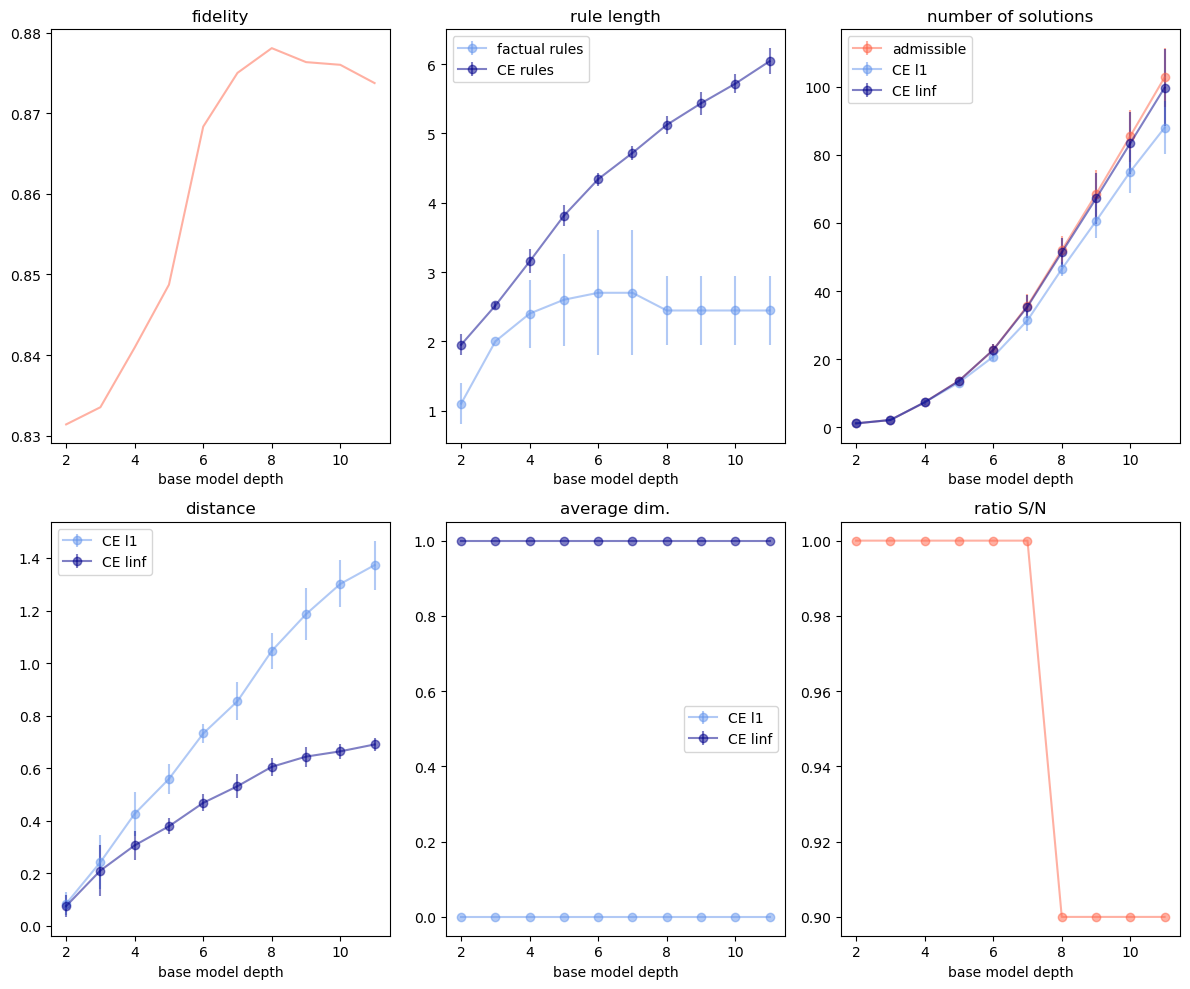

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))

nanmean_over_instances = np.nanmean(evaluation_parameters, axis = 1)
nanstd_over_instances = np.nanstd(evaluation_parameters, axis = 1)

depth = np.arange(0, max_tree_depth) + 2
print(depth)

plt.subplot(2, 3, 1)
if case == "a":
    plt.plot(depth, accuracy, color = "tomato", alpha=0.5)
    plt.title("accuracy")
if case == "b":
    plt.plot(depth, fidelity, color = "tomato", alpha=0.5)
    plt.title("fidelity")
plt.xlabel("base model depth")
if case == "c":
    plt.plot(depth, fidelity[0], color = "tomato", alpha=0.5)
    plt.title("fidelity")
plt.xlabel("base model depth")

plt.subplot(2, 3, 2)
plt.errorbar(depth, nanmean_over_instances[1], nanstd_over_instances[1], marker='o', color = "cornflowerblue", label = "factual rules", alpha = 0.5)
plt.errorbar(depth, nanmean_over_instances[2], nanstd_over_instances[2], marker = 'o', color = "darkblue", label = "CE rules", alpha = 0.5)
plt.legend()
plt.title("rule length")
plt.xlabel("base model depth")

plt.subplot(2,3,3)
plt.errorbar(depth, nanmean_over_instances[3], nanstd_over_instances[3], marker = 'o', alpha = 0.5, color = 'tomato', label = "admissible")
plt.errorbar(depth, nanmean_over_instances[4], nanstd_over_instances[4], marker = 'o', alpha = 0.5, color = 'cornflowerblue', label = 'CE l1')
plt.errorbar(depth, nanmean_over_instances[7], nanstd_over_instances[7], marker = 'o', alpha = 0.5, color = 'darkblue', label = 'CE linf')
plt.title("number of solutions")
plt.legend()
plt.xlabel("base model depth")

plt.subplot(2,3,4)
plt.errorbar(depth, nanmean_over_instances[5], nanstd_over_instances[5], marker = "o", color = "cornflowerblue", alpha = 0.5, label = "CE l1")
plt.errorbar(depth, nanmean_over_instances[8], nanstd_over_instances[8], marker = "o", color = "darkblue", alpha = 0.5, label = "CE linf")
plt.title("distance")
plt.xlabel("base model depth")
plt.legend()

plt.subplot(2,3,5)
plt.errorbar(depth, nanmean_over_instances[6], nanstd_over_instances[6], marker = "o", color = "cornflowerblue", alpha = 0.5, label = "CE l1")
plt.errorbar(depth, nanmean_over_instances[9], nanstd_over_instances[9], marker = "o", color = "darkblue", alpha = 0.5, label = "CE linf")
plt.title("average dim.")
plt.xlabel("base model depth")
plt.legend()

plt.subplot(2,3,6)
plt.plot(depth, np.sum(evaluation_parameters, axis = 1)[0] / instances, marker = "o", color = "tomato", alpha = 0.5)
plt.title("ratio S/N")
plt.xlabel("base model depth")

plt.tight_layout()
#plt.show()

plt.savefig('evaluation/parameter_depth_case_' + case + "_mtd_" + str(max_tree_depth) + '_instances_' + str(instances) + '.pdf')

In [10]:
X, y = df_encoded_onehot[encoded_pred_atts], df_encoded_onehot[target]
# retain test sets
X1, XT1, y1, yt1 = train_test_split(X, y, test_size=0.3, random_state=42)
X2, XT2, y2, yt2 = train_test_split(X, y, test_size=0.3, random_state=24)

instances_ = 10
confidence_ce = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
confidence_f = 0.8

evaluation_parameters_ = np.empty((10,instances_,len(confidence_ce)))
evaluation_parameters_[:] = np.nan

if case == "a":
    # fixed tree depth
    clf1 = DecisionTreeClassifier(max_depth=3)
    clf1.fit(X1, y1)
    tree_ = clf1
    print("accuracy tree        ", clf1.score(XT1, yt1))
        
    for j in range(len(confidence_ce)):
        r = reasonx.ReasonX(pred_atts, target, df_code)
        r.model(tree_)
        evaluation_parameters_[:,:,j] = evaluation_return_array(r, XT1, yt1, instances_, minconf_f=confidence_f, minconf_ce=confidence_ce[j])

if case == "b":
    xgb = XGBClassifier(random_state = 0)
    xgb.fit(X1, y1)
    xgb_label = xgb.predict(XT1)
    print("accuracy XGB         ", xgb.score(XT1, yt1))

    xgb_label_df = pd.Series(data=xgb_label)

    # split the test set (XT1/xgb_labels) in two parts
    XT1_train, XT1_test, xgb_label_train, xgb_label_test = train_test_split(XT1, xgb_label_df, test_size=0.3, random_state=42)

    for j in range(len(confidence_ce)):
        # train a surrogate decision tree
        clf2 = DecisionTreeClassifier(max_depth=3)
        clf2.fit(XT1_train, xgb_label_train)
        tree_ = clf2

        r = reasonx.ReasonX(pred_atts, target, df_code)
        r.model(tree_)
        evaluation_parameters_[:,:,j] = evaluation_return_array(r, XT1_test, xgb_label_test, instances_, minconf_f=confidence_f, minconf_ce=confidence_ce[j])

if case == "c":
    xgb = XGBClassifier(random_state = 0)
    xgb.fit(X1, y1)
    xgb_label = xgb.predict(XT1)
    print("accuracy XGB         ", xgb.score(XT1, yt1))

    for i in range(instances_):
        # pick data instance
        features=XT1.iloc[i:i+1]
        label=yt1.iloc[i]
        data_numpy = XT1.to_numpy()

        # neighborhood generation
        N = 5000
        C = int(df_encoded_onehot.shape[1] * 2 / 3)
        neigh = naive_neighborhood_instance(features.to_numpy(), C, N, np.transpose(data_numpy), 42)

        # predict labels of neigh
        label_neigh = xgb.predict(neigh)

        # split neigh
        neigh_train, neigh_test, neigh_label_train, neigh_label_test = train_test_split(neigh, label_neigh, test_size=0.3, random_state=42)
        
        # train surrogate DT
        clf2 = DecisionTreeClassifier(max_depth=3)
        clf2.fit(neigh_train, neigh_label_train)
        
        for j in range(len(confidence_ce)):
            # execute the evaluation
            r = reasonx.ReasonX(pred_atts, target, df_code)
            r.model(clf2)
            # compute evaluation only for data instance in focus
            evaluation_parameters_[:,i,j] = evaluation_return_array(r, features, label, n_instances = 1, minconf_f=confidence_f, minconf_ce=confidence_ce[j]).flatten()


accuracy XGB          0.8514297413498942
data set size (20, 14653)
dimensions upper/lower bound arrays 20 20
F.race = White, F.sex = Male, F.workclass = Private, F.education = HSgrad, F.age = 18, F.capitalgain = 0, F.capitalloss = 0, F.hoursperweek = 20
---
Answer constraint: F.race=White,F.sex=Male,F.workclass=Private,F.education=9.0,F.age=18.0,F.capitalgain=0.0,F.capitalloss=0.0,F.hoursperweek=20.0
Rule satisfied by F: IF F.capitalgain<=4252.0,F.education<=15.5 THEN <=50K [1.0000]
---
Answer constraint: F.race=White,F.sex=Male,F.workclass=Private,F.education=9.0,F.age=18.0,F.capitalgain=0.0,F.capitalloss=0.0,F.hoursperweek=20.0,CF.capitalgain>4252.0,CF.capitalgain<=4296.5
Rule satisfied by F: IF F.capitalgain<=4252.0,F.education<=15.5 THEN <=50K [1.0000]
Rule satisfied by CF: IF CF.capitalgain>4252.0,CF.capitalgain<=4296.5 THEN >50K [1.0000]
---
Answer constraint: F.race=White,F.sex=Male,F.workclass=Private,F.education=9.0,F.age=18.0,F.capitalgain=0.0,F.capitalloss=0.0,F.hoursperweek

In [11]:
# safe results
reshaped = evaluation_parameters_.reshape(evaluation_parameters_.shape[0], -1)
np.savetxt('evaluation/parameter_minconf_case_' + case + '_instances_' + str(instances_) + '.csv', reshaped, delimiter=",")

# test whether properely saved
load = np.loadtxt('evaluation/parameter_minconf_case_' + case + '_instances_' + str(instances_) + '.csv', delimiter=",")
load_original = load.reshape((evaluation_parameters_.shape[0], evaluation_parameters_.shape[1], evaluation_parameters_.shape[2]))
 
# Verify if the loaded array matches the original
#print(load_original == evaluation_parameters)
if np.allclose(load_original, evaluation_parameters_, equal_nan=True):
    print("Yes, both the arrays are the same")
else:
    print("No, both the arrays are not the same")

Yes, both the arrays are the same


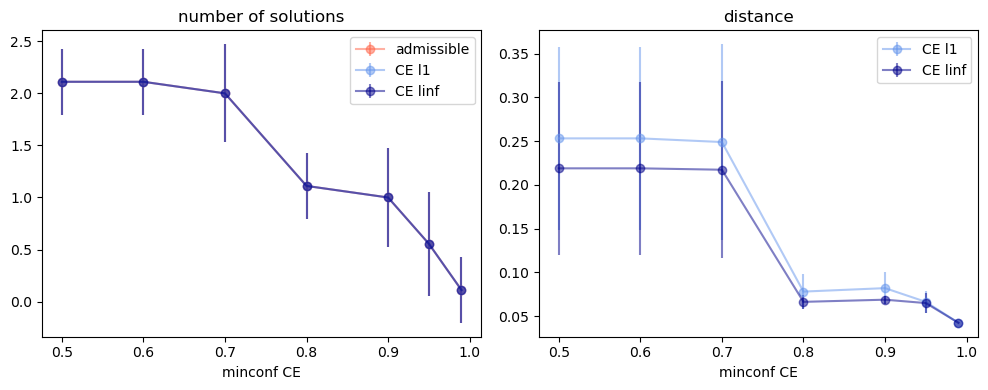

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))

nanmean_over_instances_ = np.nanmean(evaluation_parameters_, axis = 1)
nanstd_over_instances_ = np.nanstd(evaluation_parameters_, axis = 1)

# for plotting only: replace nan values in distances with zero (otherwise no plots, but should not be part of averages)
replaced_mean_dist_l1 = np.nan_to_num(nanmean_over_instances_[5])
replaced_std_dist_l1 = np.nan_to_num(nanstd_over_instances_[5])
replaced_mean_dist_linf = np.nan_to_num(nanmean_over_instances_[8])
replaced_std_dist_linf = np.nan_to_num(nanstd_over_instances_[8])

plt.subplot(1,2,1)
plt.errorbar(confidence_ce, nanmean_over_instances_[3], nanstd_over_instances_[3], marker = 'o', alpha = 0.5, color = 'tomato', label = "admissible")
plt.errorbar(confidence_ce, nanmean_over_instances_[4], nanstd_over_instances_[4], marker = 'o', alpha = 0.5, color = 'cornflowerblue', label = 'CE l1')
plt.errorbar(confidence_ce, nanmean_over_instances_[7], nanstd_over_instances_[7], marker = 'o', alpha = 0.5, color = 'darkblue', label = 'CE linf')
plt.title("number of solutions")
plt.legend()
plt.xlabel("minconf CE")

plt.subplot(1,2,2)
plt.errorbar(confidence_ce, replaced_mean_dist_l1, replaced_std_dist_l1, marker = "o", color = "cornflowerblue", alpha = 0.5, label = "CE l1")
plt.errorbar(confidence_ce, replaced_mean_dist_linf, replaced_std_dist_linf, marker = "o", color = "darkblue", alpha = 0.5, label = "CE linf")
plt.title("distance")
plt.xlabel("minconf CE")
plt.legend()

#plt.subplot(1,3,3)
#plt.plot(confidence_ce, np.sum(evaluation_parameters_, axis = 1)[0] / instances_, marker = "o", color = "tomato", alpha = 0.5)
#plt.title("ratio S/N")
#plt.xlabel("minconf CE")

plt.tight_layout()
#plt.show()

plt.savefig('evaluation/parameter_minconf_case_' + case + '_instances_' + str(instances_) + '.pdf')

In [13]:
print("ratio S/N ", np.sum(evaluation_parameters_, axis = 1)[0] / instances_)

ratio S/N  [0.9 0.9 0.9 0.9 0.9 0.9 0.9]
